# 初始化

In [3]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')  # 返回notebook的上一级目录
# sys.path.append('E:\GitHub\QA-abstract-and-reasoning')  # 效果同上

In [4]:
# 在google colab运行则执行以下代码
try:
    from google.colab import drive
    drive_path = '/content/drive'
    working_path = drive_path + "/My Drive/QA" # 工作路径
    drive.mount(drive_path)
    os.chdir(working_path)
    sys.path.append(working_path)  # 环境变量
    print("current working directory: ", os.getcwd())
    
    # %tensorflow_version 仅存在于 Colab
    %tensorflow_version 2.x
    print("run notebook in colab")
except:
    print("no colab")

no colab


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
np.set_printoptions(suppress=True)
from utils.plot import plot_attention
from utils.saveLoader import *
from utils.config import *
from layers import *
from preprocess import Preprocess
from gensim.models.word2vec import LineSentence, Word2Vec
import tensorflow as tf
# from model_layer import seq2seq_model
import time
tf.__version__

'2.0.0'

[限制gpu内存增长](https://tensorflow.google.cn/guide/gpu#limiting_gpu_memory_growth)

In [3]:
from utils.config_gpu import config_gpu
config_gpu()

1 Physical GPUs, 1 Logical GPUs


## 加载数据

In [4]:
train_x,train_y,test_x = load_train_dataset()  # 数据集
vocab,vocab_reversed = load_vocab(VOCAB_PAD)  # vocab
embedding_matrix = np.loadtxt(EMBEDDING_MATRIX_PAD)  # 预训练层

## 设置参数

In [5]:
params = {}
params["vocab_size"] = len(vocab)
params["max_enc_len"] = train_x.shape[1]  # 260
params["max_dec_len"] = train_y.shape[1]  # 33
params["embed_size"] = embedding_matrix.shape[1]
params["enc_units"] = 32
params["attn_units"] = 10
params["dec_units"] = params["enc_units"]
params["batch_size"] = 8
params["epochs"] = 2
print(params)

{'vocab_size': 32566, 'max_enc_len': 260, 'max_dec_len': 33, 'embed_size': 300, 'enc_units': 32, 'attn_units': 10, 'dec_units': 32, 'batch_size': 8, 'epochs': 2}


## 构建训练集

In [6]:
# 取部分数据进行训练
sample_num=64
dataset = tf.data.Dataset.from_tensor_slices((train_x[:sample_num], train_y[:sample_num])).shuffle(params["batch_size"]*2+1)
dataset = dataset.batch(params["batch_size"], drop_remainder=True)

In [7]:
steps_per_epoch = sample_num//params["batch_size"]

## 构建模型

In [8]:
from seq2seq import *
model=Seq2Seq(params)

## 保存点设置

In [9]:
from utils.config import CKPT_DIR, CKPT_PREFIX
ckpt = tf.train.Checkpoint(Seq2Seq=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, CKPT_DIR, max_to_keep=5)

In [10]:
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


## 训练

[SparseCategoricalCrossentropy](https://tensorflow.google.cn/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)

In [11]:
optimizer = tf.keras.optimizers.Adam(name='Adam',learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

pad_index=vocab['<PAD>']
unk_index=vocab['<UNK>']

def loss_function(real, pred):
    pad_mask = tf.math.equal(real, pad_index)
    unk_mask = tf.math.equal(real, unk_index)
    # <PAD> 和 <UNK> 的损失都不算
    mask = tf.math.logical_not(tf.math.logical_or(pad_mask,unk_mask))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)
    # return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [12]:
@tf.function
def train_step(inp, targ):
    pad_index=vocab['<PAD>']
    unk_index=vocab['<UNK>']
    loss = 0
    
    with tf.GradientTape() as tape:
        # 1. 构建encoder
        enc_output, enc_hidden = model.call_encoder(inp)
        # 2. 复制
        dec_hidden = enc_hidden
        # 3. <START> * BATCH_SIZE 
        dec_input = tf.expand_dims([vocab['<START>']] * params["batch_size"], 1)
        
        # 逐个预测序列
        predictions, _ = model(dec_input, dec_hidden, enc_output, targ)
        
        batch_loss = loss_function(targ[:, 1:], predictions)

        variables = model.encoder.trainable_variables + model.decoder.trainable_variables+ model.attention.trainable_variables
    
        gradients = tape.gradient(batch_loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [13]:
epochs = params["epochs"]
# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
for epoch in range(epochs):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if batch % 1 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Latest checkpoint restored!!
Epoch 1 Batch 0 Loss 5.6014
Epoch 1 Batch 1 Loss 5.9667
Epoch 1 Batch 2 Loss 6.4132
Epoch 1 Batch 3 Loss 5.3579
Epoch 1 Batch 4 Loss 3.1254
Epoch 1 Batch 5 Loss 4.0590
Epoch 1 Batch 6 Loss 5.0737
Epoch 1 Batch 7 Loss 5.0737
Epoch 1 Loss 5.0839
Time taken for 1 epoch 55.26252365112305 sec

Epoch 2 Batch 0 Loss 5.5202
Epoch 2 Batch 1 Loss 6.4132
Epoch 2 Batch 2 Loss 3.8560
Epoch 2 Batch 3 Loss 5.1143
Epoch 2 Batch 4 Loss 5.1955
Epoch 2 Batch 5 Loss 4.2619
Epoch 2 Batch 6 Loss 5.0737
Epoch 2 Batch 7 Loss 5.2361
Saving checkpoint for epoch 2 at E:\GitHub\QA-abstract-and-reasoning\data\checkpoints\training_checkpoints\ckpt-2
Epoch 2 Loss 5.0839
Time taken for 1 epoch 3.052049160003662 sec



## 载入模型

In [15]:
# 如果检查点存在，则恢复最新的检查点。
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


In [16]:
def evaluate(model,inputs):
    attention_plot = np.zeros((params["max_dec_len"], params["max_enc_len"]))
    
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    
    hidden = [tf.zeros((1, params["enc_units"]))]
    enc_output, enc_hidden = model.encoder(inputs, hidden)

    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([vocab['<START>']], 0)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)

    for t in range(params["max_dec_len"]):
        
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += vocab_reversed[predicted_id] + ' '
        if vocab_reversed[predicted_id] == '<STOP>':
            return result, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [17]:
def translate(sentence):
    st = preproc.sentence_proc(sentence)
    sentence = preproc.sentence_proc_eval(sentence,params["max_enc_len"]-2,vocab)
    result, attention_plot = evaluate(model,sentence)

    print('Input: %s' % (st))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(st.split(' '))]
    plot_attention(attention_plot, st.split(' '), result.split(' '))

In [20]:
sentence = '方向机重，助力泵，方向机都换了还是一样'
preproc = Preprocess()
preproc.sentence_proc(sentence)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Light\AppData\Local\Temp\jieba.cache
Loading model cost 0.855 seconds.
Prefix dict has been built succesfully.


'方向机 重 助力 泵 方向机 都 换'

In [19]:
# import matplotlib as mpl
# mpl.rcParams['font.family'] = 'STSong'  # 显示中文

Input: 方向机 重 助力 泵 方向机 都 换
Predicted translation: 开票 老哥 改原车 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 


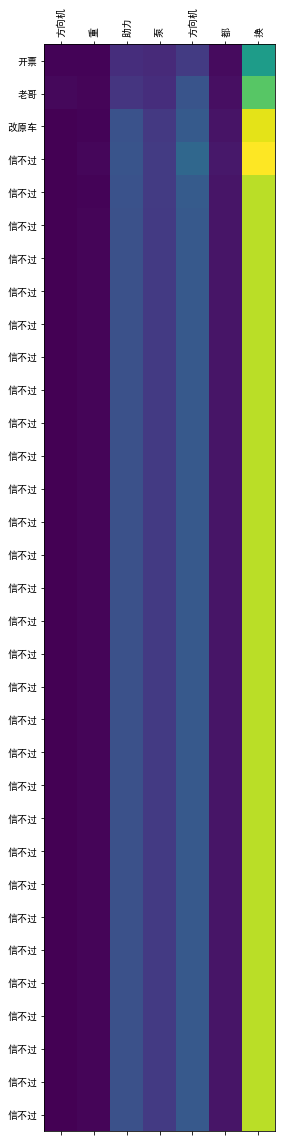

In [21]:
translate(sentence)

In [22]:
# 下半部分
assert False

AssertionError: 

In [34]:
def batch_predict(inps):
    # 判断输入长度
    batch_size=len(inps)
    # 开辟结果存储list
    preidicts=[''] * batch_size
    
    inps = tf.convert_to_tensor(inps)
    # 0. 初始化隐藏层输入
    hidden = [tf.zeros((batch_size, params["enc_units"]))]
    # 1. 构建encoder
    enc_output, enc_hidden = model.encoder(inps, hidden)
    # 2. 复制
    dec_hidden = enc_hidden
    # 3. <START> * BATCH_SIZE 
    dec_input = tf.expand_dims([vocab['<START>']] * batch_size, 1)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)
    # Teacher forcing - feeding the target as the next input
    for t in range(params["max_dec_len"]):
        # 计算上下文
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        # 单步预测
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)
        
        # id转换 贪婪搜索
        predicted_ids = tf.argmax(predictions,axis=1).numpy()
        
        
        for index,predicted_id in enumerate(predicted_ids):
            preidicts[index]+= vocab_reversed[predicted_id] + ' '
        
        # using teacher forcing
        dec_input = tf.expand_dims(predicted_ids, 1)

    results=[]
    for preidict in preidicts:
        # 去掉句子前后空格
        preidict=preidict.strip()
        # 句子小于max len就结束了 截断
        if '<STOP>' in preidict:
            # 截断stop
            preidict=preidict[:preidict.index('<STOP>')]
        # 保存结果
        results.append(preidict)
    return results

In [52]:
# 测试代码
# ds = iter(dataset)
# x,y = ds.next()
# batch_predict(x)

In [53]:
from tqdm import tqdm
import math

In [59]:
def model_predict(data_X, batch_size):
    # 存储结果
    results=[]
    # 样本数量
    sample_size=len(data_X)
    # batch 操作轮数 math.ceil向上取整 小数 +1
    # 因为最后一个batch可能不足一个batch size 大小 ,但是依然需要计算  
    steps_epoch = math.ceil(sample_size/batch_size)
    # [0,steps_epoch)
    for i in tqdm(range(steps_epoch)):
        batch_data = data_X[i*batch_size:(i+1)*batch_size]
        results+=batch_predict(batch_data)
    return results

In [66]:
%%time
results=model_predict(train_x[:sample_num+1],batch_size=4)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s]

Wall time: 6.88 s
